In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Now you can zoom
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [3]:
import os
import struct
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [4]:
# Hyperparameters
import os
epochs = 1 #Repeat training with same dataset
batch_size = 10#divide dataset in batches of this size for training
learning_rate = .01

input_size = 28
mnist = MNIST(os.getcwd())

In [5]:
graph = tf.Graph()

learning_rate = 1e-4

with graph.as_default():#Override default graph if running cell multiple times
    input_layer = tf.placeholder(tf.float32, shape = [None, input_size, input_size])
    input_layer1 = tf.expand_dims(input_layer,3)
    labels = tf.placeholder(tf.int64, shape = [None])
    print(input_layer1.shape)
    
    with tf.variable_scope("CNN_and_maxpool_1"):
        kernels_1 = tf.Variable(tf.truncated_normal([5, 5, 1, 16], stddev = 0.1))
        convolution_1 = tf.nn.conv2d(input_layer1, kernels_1, strides = [1, 1, 1, 1], padding = "SAME")
        
        biases_1 = tf.Variable(tf.constant(0.0, shape = [16]))
        feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1)
        pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
    
    print(feature_maps_1.shape)
    print(pool_1.shape)    
    with tf.variable_scope("CNN_and_maxpool_2"):
        kernels_2 = tf.Variable(tf.truncated_normal([3, 3, 16, 32], stddev = 0.1))
        convolution_2 = tf.nn.conv2d(pool_1, kernels_2, strides = [1, 1, 1, 1], padding = "SAME")
        biases_2 = tf.Variable(tf.constant(0.0, shape = [32]))
        feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2)
        pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")
    
    print(feature_maps_2.shape)
    print(pool_2.shape)
    
    with tf.variable_scope("Fully_connected_layers"):
        flattened = tf.reshape(pool_2, [-1, 7*7*32 ]) ##TO BE ADJUSTED: MUST MATCH NUMBER OF NEUROS OF PREVIOUS layer
        print(str(flattened.shape))

        weights_3 = tf.Variable(tf.truncated_normal([7*7*32, 512], stddev = 2048**(-1/2)))#TO BE ADJUSTED
        biases_3 = tf.Variable(tf.constant(0.0, shape = [512]))
        hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3)
        print(hidden_layer.shape)

        weights_4 = tf.Variable(tf.truncated_normal([512, 10], stddev = 512**(-1/2)))
        biases_4 = tf.Variable(tf.constant(0.0, shape = [10]))
        output_layer_logits = tf.matmul(hidden_layer, weights_4) + biases_4
        label = tf.argmax(output_layer_logits,1)

        print(output_layer_logits.shape)

        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = output_layer_logits)
        cross_entropy = tf.reduce_mean(cross_entropy)
    
    with tf.variable_scope("Optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        optimization_step = optimizer.minimize(cross_entropy)
    
    with tf.variable_scope("Accuracy"):
        accuracy = tf.equal(tf.argmax(tf.nn.softmax(output_layer_logits), 1), labels)
        accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))
        
    saver = tf.train.Saver()

(?, 28, 28, 1)
Instructions for updating:
Colocations handled automatically by placer.
(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 7, 7, 32)
(?, 1568)
(?, 512)
(?, 10)


In [6]:
def mean_accuracy(steps = 10, mode = "validation"):
    #Here we do the forward step 10 times and return the average accuracy
    prelim_mean = 0.0
    _accuracy = 0.0
    step = 0
    
    if mode == "validation":
        batches = mnist.get_validation_batch(batch_size)
    if mode == "test":
        batches = mnist.get_test_batch(batch_size)
        
    for batch, label_batch in mnist.get_training_batch(batch_size):

            _accuracy, _ = session.run(
                [accuracy, optimization_step],
                    feed_dict = {
                        input_layer: batch,
                        labels : label_batch
                    }
                )
            #summery_file_writer.add_summary(_summary, step) #write summary to file
            step += 1
            prelim_mean += _accuracy
            if step == steps:
                return prelim_mean/step
    return prelim_mean/step

In [7]:
with graph.as_default():
    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    
    step = 1
    for epoch in range(epochs):

        print('Epoch = ', epoch + 1)
        
        for batch, label_batch in mnist.get_training_batch(batch_size = batch_size):
            _accuracy, _ = session.run([accuracy, optimization_step],feed_dict = { input_layer: batch,labels : label_batch })
                
            step += 1                                
            if ((step % 50)==0):
                validation_accuracy = mean_accuracy(10)
                print('Step = ' + str(step) + '; Accuracy = ' + str(validation_accuracy))

    
    #Test accuracy
    test_accuracy = mean_accuracy(-1,"test")
    print("\n Test accuracy = " + str(test_accuracy))

Epoch =  1
Step = 50; Accuracy = 0.6900000035762787
Step = 100; Accuracy = 0.7899999916553497
Step = 150; Accuracy = 0.8899999916553497
Step = 200; Accuracy = 0.8799999833106995
Step = 250; Accuracy = 0.8699999988079071
Step = 300; Accuracy = 0.9399999856948853
Step = 350; Accuracy = 0.9199999928474426
Step = 400; Accuracy = 0.9199999928474426
Step = 450; Accuracy = 0.949999988079071
Step = 500; Accuracy = 0.9199999809265137
Step = 550; Accuracy = 0.8899999976158142
Step = 600; Accuracy = 0.8999999940395356
Step = 650; Accuracy = 0.9499999940395355
Step = 700; Accuracy = 0.9099999904632569
Step = 750; Accuracy = 0.949999988079071
Step = 800; Accuracy = 0.9300000011920929
Step = 850; Accuracy = 0.9799999952316284
Step = 900; Accuracy = 0.9399999916553498
Step = 950; Accuracy = 0.9699999988079071
Step = 1000; Accuracy = 0.9399999916553498
Step = 1050; Accuracy = 0.949999988079071
Step = 1100; Accuracy = 0.9499999940395355
Step = 1150; Accuracy = 0.9599999964237214
Step = 1200; Accuracy =

In [8]:
with tf.Session() as sess:
    save_path = saver.save(session, "/tmp/model3.ckpt")
    print("Model saved in path: %s" % save_path)

Model saved in path: /tmp/model3.ckpt


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/model3.ckpt
Model restored.
5


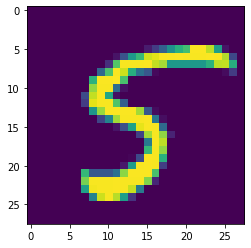

In [9]:
import matplotlib.pyplot as plt
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(session, "/tmp/model3.ckpt")
    print("Model restored.")
    pic = mnist.get_test_batch(1)
    pic = next(pic)[0]
    plt.imshow(pic[0,:,:])
    prediction = session.run([label],feed_dict = {input_layer: pic})
    print(prediction[0][0])